In [5]:
import pandas as pd
import requests
import zipfile
import io


In [6]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'

# Download the outer ZIP file
response = requests.get(url)
outer_zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# List all files in the outer ZIP
print("Files in the outer ZIP:", outer_zip_file.namelist())

# Choose the specific inner ZIP file you want to extract
inner_zip_filename = 'bank.zip'  # or 'bank.zip'

# Extract the inner ZIP file
with outer_zip_file.open(inner_zip_filename) as inner_zip:
    inner_zip_file = zipfile.ZipFile(io.BytesIO(inner_zip.read()))

    # List all files in the inner ZIP
    print("Files in the inner ZIP:", inner_zip_file.namelist())

    # Choose the specific CSV file you want to read
    csv_filename = 'bank-full.csv'  # Replace with the actual CSV file name

    # Read the specific CSV file
    with inner_zip_file.open(csv_filename) as file:
        df = pd.read_csv(file, sep=';')  # Use the correct separator if needed

# Now you can work with the DataFrame `df`
print(df.head())

Files in the outer ZIP: ['bank.zip', 'bank-additional.zip']
Files in the inner ZIP: ['bank-full.csv', 'bank-names.txt', 'bank.csv']
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1     

In [8]:
column_list = [ 'age','job','marital','education','balance','housing',
'contact','day','month','duration','campaign','pdays','previous','poutcome','y']
df_hw04 = df[column_list]

In [9]:
df_hw04.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [24]:
X = df_hw04.drop('y', axis=1)
y = df_hw04['y']
y= (y == 'yes').astype('int')

In [25]:
from sklearn.model_selection import train_test_split

X_train_full,  X_test, y_train_full, y_test = train_test_split(X, y,  test_size=0.2, random_state=1)
X_train, X_val,y_train,  y_val =train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)

In [26]:
numerical_columns = X_train.select_dtypes(include=['number']).columns

In [31]:
#Q1 ROC AUC feature importance
from sklearn.metrics import  roc_auc_score, auc
from sklearn.linear_model import LogisticRegression

In [57]:
feature_importance = {}

# Iterate over each feature
for feature in X_train[['balance', 'day', 'duration', 'previous']].columns:
    # Create a simple model pipeline with scaling and logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    
    # Fit the model using only the current feature
    model.fit(X_train[[feature]], y_train)
    
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_val[[feature]])[:, 1]
    
    # Calculate the ROC AUC score
    auc_score = roc_auc_score(y_val, y_pred_prob)
    
    # Store the score in the dictionary
    feature_importance[feature] = auc_score

# Print the feature importance
for feature, score in feature_importance.items():
    print(f"Feature: {feature},  AUC Score: {score}")

feature_importance

Feature: balance,  AUC Score: 0.5995068851725284
Feature: day,  AUC Score: 0.5352198426324892
Feature: duration,  AUC Score: 0.7965344730967409
Feature: previous,  AUC Score: 0.607255799705406


{'balance': np.float64(0.5995068851725284),
 'day': np.float64(0.5352198426324892),
 'duration': np.float64(0.7965344730967409),
 'previous': np.float64(0.607255799705406)}

In [58]:
print(f"A1 the variable '{sorted(feature_importance, key=lambda x:x[1], reverse=True)[0]}' has the highest AUC score")

A1 the variable 'duration' has the highest AUC score


In [87]:
from sklearn.feature_extraction import DictVectorizer
def get_auc_score(feature_vector, C=1.0):
    # Transform the training and validation data using the selected features
    X_train_selected = X_train[feature_vector].to_dict(orient='records')
    X_val_selected = X_val[feature_vector].to_dict(orient='records')
    
    # Vectorize the selected features
    dv_small = DictVectorizer(sparse=False)
    X_train_transformed = dv_small.fit_transform(X_train_selected)
    X_val_transformed = dv_small.transform(X_val_selected)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train_transformed, y_train)
    print("N_iteration: :", model.n_iter_)
    
    # Predict on the validation set
    y_pred = model.predict_proba(X_val_transformed)[:, 1]
    
    
    # Calculate accuracy
    auc_score = roc_auc_score(y_val, y_pred)
    print(f"Accuracy with features {feature_vector}: {auc_score}")
    return auc_score, y_pred, y_val

In [80]:
feature_vector = feature_list
C=1
X_train_selected = X_train[feature_vector].to_dict(orient='records')
X_val_selected = X_val[feature_vector].to_dict(orient='records')
    
    # Vectorize the selected features
dv_small = DictVectorizer(sparse=False)
X_train_transformed = dv_small.fit_transform(X_train_selected)
X_val_transformed = dv_small.transform(X_val_selected)
    
    # Train the model
model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
model.fit(X_train_transformed, y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [65]:
feature_list = X_train.columns

In [88]:
auc_score, _, _ = get_auc_score(feature_vector=feature_list)
print(f"A2 the AUC on this model is {round(auc_score,3)}")

N_iteration: : [33]
Accuracy with features Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome'],
      dtype='object'): 0.9000187102064178
A2 the AUC on this model is 0.9


In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_score, recall_score
import numpy as np

N_iteration: : [35]
Accuracy with features Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome'],
      dtype='object'): 0.8999702150022839


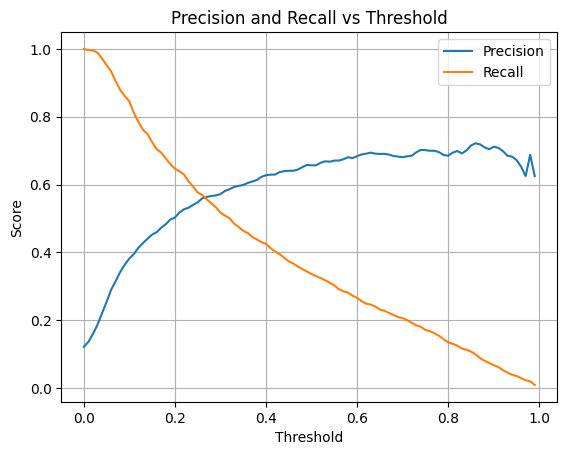

A3 Precision and recall curves intersect at threshold: 0.270
A4 F1 Score is max at threshold: 0.220


In [92]:
# Define thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.0, 0.01)

# Initialize lists to store precision and recall values
precision = []
recall = []
f1_score = []


_,y_scores, y_true = get_auc_score(feature_vector=feature_list)

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_scores >= threshold).astype(int)
    
    # Calculate precision and recall
    P = precision_score(y_true, y_pred)
    R = recall_score(y_true, y_pred)
    precision.append(P)
    recall.append(R)
    f1_score.append((P * R) / (P + R))

# Plot precision and recall
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Find the threshold where precision and recall intersect
intersection_idx = np.argmin(np.abs(np.array(precision) - np.array(recall)))
f1_score_max_idx = np.argmax(np.abs(np.array(f1_score)))
intersection_threshold = thresholds[intersection_idx]
f1_score_max = thresholds[f1_score_max_idx]
print(f"A3 Precision and recall curves intersect at threshold: {intersection_threshold:.3f}")
print(f"A4 F1 Score is max at threshold: {f1_score_max:.3f}")

In [102]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

feature_vector = feature_list

for C in [0.000001, 0.001, 1]:
    auc_scores = []
    for train_index, val_index in kf.split(X_train_full):
    
        
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
        
            
        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        X_train_selected = X_train[feature_vector].to_dict(orient='records')
        X_val_selected = X_val[feature_vector].to_dict(orient='records')
        # Vectorize the selected features
        dv_kfold = DictVectorizer(sparse=False)
        X_train_transformed = dv_kfold.fit_transform(X_train_selected)
        X_val_transformed = dv_kfold.transform(X_val_selected)
        model.fit(X_train_transformed, y_train)
        
        y_pred = model.predict_proba(X_val_transformed)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
       
    print(f'Regularization parameter C: {C}')
    print(f'The mean AUC scores: {round(np.mean(auc_scores),3)}')
    print(f'The Standard deviation of AUC scores: {round(np.std(auc_scores),3)}')

Regularization parameter C: 1e-06
The mean AUC scores: 0.906
The Standard deviation of AUC scores: 0.006
Regularization parameter C: 0.001
The mean AUC scores: 0.906
The Standard deviation of AUC scores: 0.006
Regularization parameter C: 1
The mean AUC scores: 0.906
The Standard deviation of AUC scores: 0.006
